**DEEP LEARNING BASED SENTIMENT ANALYSIS OF MOVIE REVIEWS**

In [1]:
# Importing essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten 
from tensorflow.keras.layers import GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [2]:
# Importing IMDb Movie Reviews dataset
movie_reviews = pd.read_excel("C:\\Users\\User\\Downloads\\IMDB Dataset.xlsx")
movie_reviews

review sentiment
0     One of the other reviewers has mentioned that ...  positive
1     A wonderful little production. <br /><br />The...  positive
2     I thought this was a wonderful way to spend ti...  positive
3     Basically there's a family where a little boy ...  negative
4     Petter Mattei's "Love in the Time of Money" is...  positive
...                                                 ...       ...
1109  I have not read the book that this was based u...  positive
1110  Brilliant thriller, deserving far more fame, M...  positive
1111  I saw this movie a fews years ago and was lite...  positive
1112  I just watched this movie on Bravo! and it was...  negative
1113  How nice to have a movie the entire family can...  positive

[1114 rows x 2 columns]

In [3]:
# Dataset exploration
movie_reviews.shape

(1114, 2)

In [4]:
# Checking for missing values
movie_reviews.isnull().values.any()

False

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

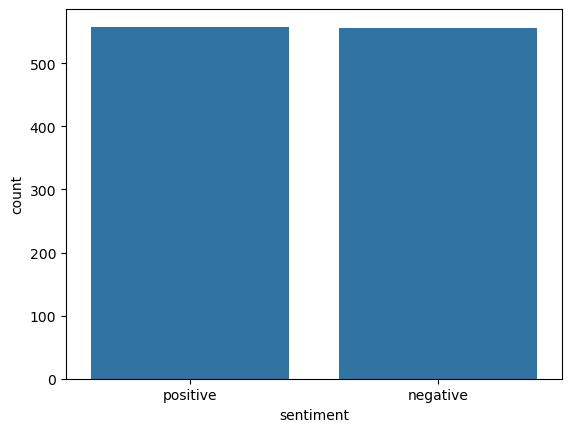

In [5]:
# Let's observe distribution of positive / negative sentiments in dataset
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)
movie_reviews["review"][2]

In [6]:
# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''
    return TAG_RE.sub('', text)


In [7]:
import nltk
nltk.download('stopwords')
def preprocess_text(sen):
    
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z
    only in lowercase'''
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)


    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # When we remove apostrophe from the word
    #"Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s"
    #that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence) # Next, we remove all the single characters and replace it
    #by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from
    #our text as well.
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    
    return sentence

# Calling preprocessing_text function on movie_reviews
X = []

sentences = list(movie_reviews['review'])

for sen in sentences:
    X.append(preprocess_text(sen))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [9]:
# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here
# Converting sentiment labels to 0 & 1
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))
print(y)

[1 1 1 ... 1 0 1]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

In [11]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [12]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

16407

In [13]:
len(X_train[0]),len(X_train[1])

(64, 134)

In [14]:
# Padding all reviews to fixed length 100
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
len(X_train[0]),len(X_train[1])

(100, 100)

In [16]:
# Open the file in read mode with UTF-8 encoding
with open('C:\\Users\\User\\Downloads\\glove.6B.100d.txt', 'r', encoding='utf8') as glove_file:
    for line in glove_file:
        print(line[:100])  # Print first 100 characters of each line

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 
, -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81
. -0.33979 0.20941 0.46348 -0.64792 -0.38377 0.038034 0.17127 0.15978 0.46619 -0.019169 0.41479 -0.3
of -0.1529 -0.24279 0.89837 0.16996 0.53516 0.48784 -0.58826 -0.17982 -1.3581 0.42541 0.15377 0.2421
to -0.1897 0.050024 0.19084 -0.049184 -0.089737 0.21006 -0.54952 0.098377 -0.20135 0.34241 -0.092677
and -0.071953 0.23127 0.023731 -0.50638 0.33923 0.1959 -0.32943 0.18364 -0.18057 0.28963 0.20448 -0.
in 0.085703 -0.22201 0.16569 0.13373 0.38239 0.35401 0.01287 0.22461 -0.43817 0.50164 -0.35874 -0.34
a -0.27086 0.044006 -0.02026 -0.17395 0.6444 0.71213 0.3551 0.47138 -0.29637 0.54427 -0.72294 -0.004
" -0.30457 -0.23645 0.17576 -0.72854 -0.28343 -0.2564 0.26587 0.025309 -0.074775 -0.3766 -0.057774 0
's 0.58854 -0.2025 0.73479 -0.68338 -0.19675 -0.1802 -0.39177 0.34172 -0.60561 0.63816 -0.2

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



vantu 0.20101 -0.0048231 -0.23572 -0.084463 0.15249 -0.30473 0.2454 -0.053061 0.21879 -0.32159 0.186
mdsd -0.60562 0.75033 0.10718 0.13174 -0.6743 -0.0070359 0.089054 -0.41165 1.2419 -0.17352 0.94465 0
haijun -0.082457 -0.50132 -0.33083 0.12131 0.50946 -0.40118 0.34698 -0.24647 0.60432 -0.35486 0.0526
agaist 0.1629 -0.22335 0.15333 0.51111 0.2231 0.1487 -0.27139 -0.22452 -0.0030416 0.65915 -0.05479 0
66-61 -0.10951 -0.3472 0.11241 0.26825 0.3222 -0.019103 0.18984 -0.021257 0.11727 -0.11595 -0.47311 
noaki 0.44511 0.1601 -0.82684 0.32338 0.17249 0.47612 0.24101 -0.41389 0.40738 0.38665 -0.36906 -0.3
0-5-2 0.21226 0.22711 0.035611 -0.5273 -0.38514 0.59034 0.059044 0.71508 -0.20884 -0.47996 0.55815 -
collinelli 0.67928 -0.40126 -0.4086 0.55215 0.19274 -0.054225 -0.055288 -0.38273 -0.16854 0.031984 0
101-92 -0.043187 -0.024809 0.45435 0.12236 0.15785 0.075319 0.34544 -0.27166 0.024266 0.023354 -0.83
xiexia 0.27495 0.010114 -0.012721 1.1066 0.44097 -0.7395 -0.12737 0.099638 -0.25764 -0.4980

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [17]:
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open('C:\\Users\\User\\Downloads\\glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [19]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.
embedding_matrix = zeros((vocab_length, 100))

for word, index in word_tokenizer.word_index.items():
    
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(16407, 100)

In [20]:
# Neural Network architecture
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix],
                            input_length=maxlen , trainable=False)
snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Model compiling
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,640,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,640,700 (6.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,640,700 (6.26 MB)

None


In [22]:
# Model training
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, 
                                  epochs=6, verbose=1,validation_split=0.2)

Epoch 1/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - acc: 0.5354 - loss: 0.7513 - val_acc: 0.5587 - val_loss: 0.7171
Epoch 2/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.6646 - loss: 0.5921 - val_acc: 0.5698 - val_loss: 0.6981
Epoch 3/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.7953 - loss: 0.4730 - val_acc: 0.6536 - val_loss: 0.6458
Epoch 4/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.8922 - loss: 0.3883 - val_acc: 0.6201 - val_loss: 0.6388
Epoch 5/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - acc: 0.9572 - loss: 0.3087 - val_acc: 0.6872 - val_loss: 0.6253
Epoch 6/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.9657 - loss: 0.2733 - val_acc: 0.6480 - val_loss: 0.6221


In [25]:
# Predictions on the Test Set
score = snn_model.evaluate(X_test, y_test, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.6104 - loss: 0.6824


In [26]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6564987897872925
Test Accuracy: 0.6188340783119202


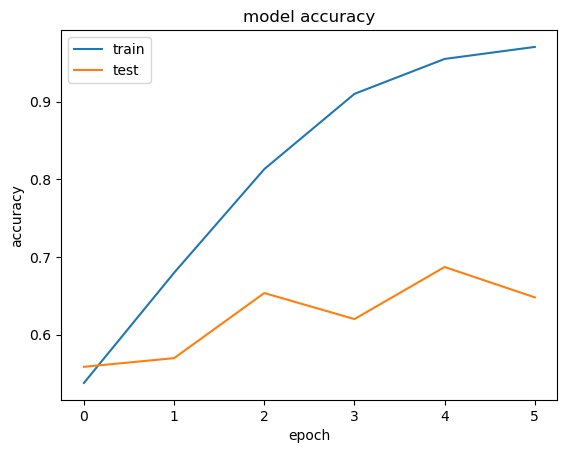

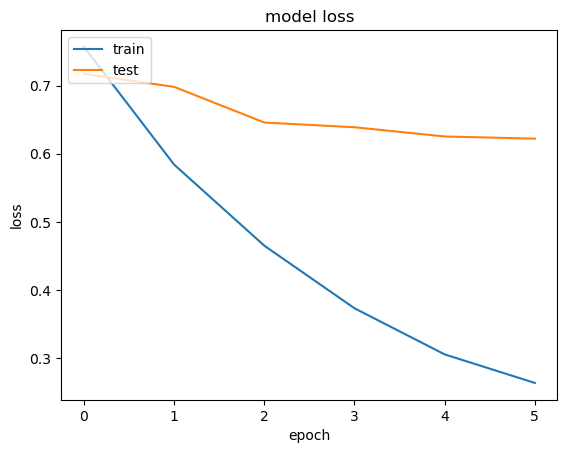

In [27]:
# Model Performance Charts
import matplotlib.pyplot as plt
plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [28]:
from keras.layers import Conv1D

# Neural Network architecture

cnn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix],
input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [29]:
# Model compiling
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,640,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,640,700 (6.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,640,700 (6.26 MB)

None


In [30]:
# Model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, 
                                  epochs=6, verbose=1,validation_split=0.2)

Epoch 1/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - acc: 0.4897 - loss: 1.0908 - val_acc: 0.5363 - val_loss: 0.7866
Epoch 2/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - acc: 0.5648 - loss: 0.7072 - val_acc: 0.5140 - val_loss: 0.7746
Epoch 3/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - acc: 0.6243 - loss: 0.5918 - val_acc: 0.5587 - val_loss: 0.6434
Epoch 4/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - acc: 0.7844 - loss: 0.4990 - val_acc: 0.6425 - val_loss: 0.6239
Epoch 5/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - acc: 0.8568 - loss: 0.4401 - val_acc: 0.6369 - val_loss: 0.6457
Epoch 6/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - acc: 0.9124 - loss: 0.4006 - val_acc: 0.6313 - val_loss: 0.6070


In [31]:
# Predictions on the Test Set
score = cnn_model.evaluate(X_test, y_test, verbose=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.6256 - loss: 0.6393


In [32]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Test Score: 0.6294540762901306
Test Accuracy: 0.6322869658470154


In [34]:
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       1,640,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 128)             │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,833,473 (6.99 MB)

 Trainable params: 64,257 (251.00 KB)

 Non-trainable params: 1,640,700 (6.26 MB)

 Optimizer params: 128,516 (502.02 KB)

None


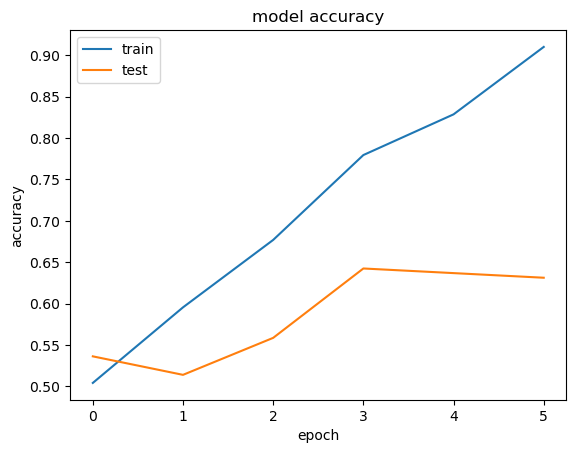

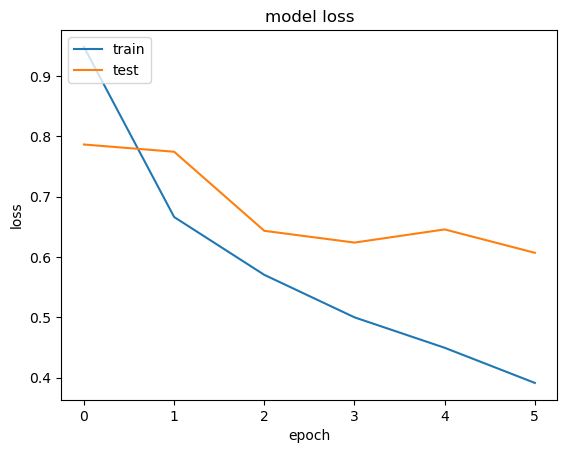

In [35]:
# Model Performance Charts
import matplotlib.pyplot as plt
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()
plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [36]:
from keras.layers import LSTM
# Neural Network architecture
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix],
input_length=maxlen , trainable=False)
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))
lstm_model.add(Dense(1, activation='sigmoid'))


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [37]:
# Model compiling
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       1,640,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,640,700 (6.26 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,640,700 (6.26 MB)

None


In [39]:
# Model Training
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, 
                                    epochs=6, verbose=1,validation_split=0.2)

Epoch 1/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - acc: 0.7589 - loss: 0.5213 - val_acc: 0.7151 - val_loss: 0.5313
Epoch 2/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step - acc: 0.7980 - loss: 0.4977 - val_acc: 0.7207 - val_loss: 0.5535
Epoch 3/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step - acc: 0.8127 - loss: 0.4549 - val_acc: 0.7542 - val_loss: 0.5416
Epoch 4/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 349ms/step - acc: 0.7984 - loss: 0.4612 - val_acc: 0.7207 - val_loss: 0.5675
Epoch 5/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - acc: 0.8016 - loss: 0.4805 - val_acc: 0.7207 - val_loss: 0.5599
Epoch 6/6
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - acc: 0.8021 - loss: 0.4483 - val_acc: 0.7207 - val_loss: 0.5783


In [40]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - acc: 0.6921 - loss: 0.6533


In [41]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Test Score: 0.6076445579528809
Test Accuracy: 0.7219731211662292


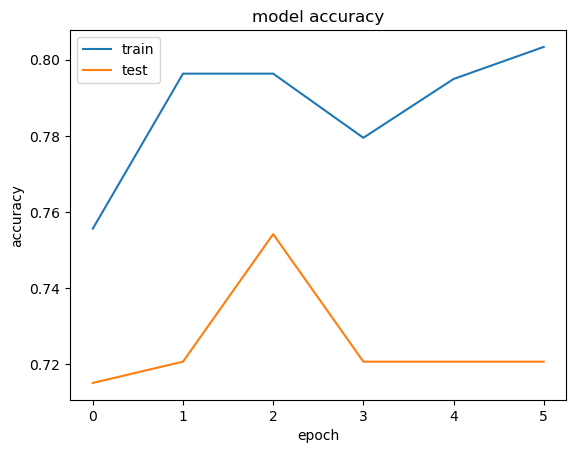

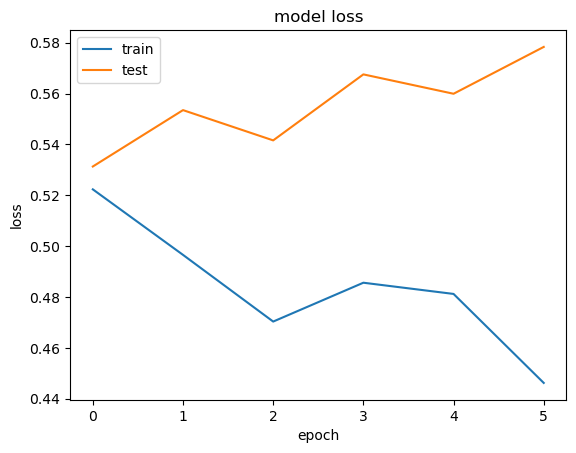

In [42]:
# Model Performance Charts
import matplotlib.pyplot as plt
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [43]:
sample_reviews = pd.read_excel("C:\\Users\\User\\Downloads\\IMDB Dataset.xlsx")
sample_reviews.head(6)

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
5  Probably my all-time favorite movie, a story o...  positive

In [46]:
# Preprocess review text with earlier defined preprocess_text function
unseen_reviews = sample_reviews['review']
unseen_processed = []

for review in unseen_reviews:
    review = preprocess_text(review)
    unseen_processed.append(review)

In [49]:
unseen_processed[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [50]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)
# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)
unseen_sentiments

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step


array([[0.7258887 ],
       [0.8881941 ],
       [0.89816177],
       ...,
       [0.87172186],
       [0.09935676],
       [0.86971295]], dtype=float32)

In [56]:
sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)
df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'],
                                        columns = ['Predicted Sentiments'])

df_movie = pd.DataFrame(sample_reviews['sentiment'], columns = ['sentiment'])
df_review_text = pd.DataFrame(sample_reviews['review'], columns = ['review'])
dfx=pd.concat([df_movie, df_review_text , df_prediction_sentiments], axis=1)
dfx.head(6)

sentiment                                             review  \
0  positive  One of the other reviewers has mentioned that ...   
1  positive  A wonderful little production. <br /><br />The...   
2  positive  I thought this was a wonderful way to spend ti...   
3  negative  Basically there's a family where a little boy ...   
4  positive  Petter Mattei's "Love in the Time of Money" is...   
5  positive  Probably my all-time favorite movie, a story o...   

   Predicted Sentiments  
0                   7.3  
1                   8.9  
2                   9.0  
3                   1.0  
4                   8.6  
5                   8.6